# Data Preparation

In Collaborative Filtering, we can provide recommendations based to a user based on what other users who have similar reviews like them have liked. Below I imported the libraries and three datasets and prepared data frames for further training. 

In [2]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

Instructions for updating:
non-resource variables are not supported in the long term


Instructions for updating:
non-resource variables are not supported in the long term


In [3]:
# Loading in the ratings, users and books datasets
ratings_data = pd.read_csv('Ratings.csv')
users_data = pd.read_csv('Users.csv')
books_data = pd.read_csv('Books.csv')

/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


I removed zeroes from the Rating dataset because it means users have not read these books. For the training, we are only interested in books that have been read. Thus, I selected rows only where ratings are non-zero values. As a result, we get more accurate results. 

In [4]:
ratings_data = ratings_data[ratings_data['Book-Rating'] != 0]
ratings_data.head()

,User-ID,ISBN,Book-Rating
1,276726,0155061224,5
3,276729,052165615X,3
4,276729,0521795028,6
6,276736,3257224281,8
7,276737,0600570967,6


In [5]:
users_data.head()

,User-ID,Location,Age
0,1,"nyc, new york, usa",NaN
1,2,"stockton, california, usa",18.0
2,3,"moscow, yukon territory, russia",NaN
3,4,"porto, v.n.gaia, portugal",17.0
4,5,"farnborough, hants, united kingdom",NaN


In [6]:
books_data.head()

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...


In [7]:
# printing shapes of these datasets
print("Shape of books dataset: ",books_data.shape)
print("Shape of users dataset: ",users_data.shape)
print("Shape of ratings dataset: ",ratings_data.shape)

Shape of books dataset:  (271360, 8)
Shape of users dataset:  (278858, 3)
Shape of ratings dataset:  (433671, 3)


To prevent memory indexing errors when we index books through their ISBN, I created a column for indices to show which row the book is located. It also becomes more convenient to select books if their index is known.

In [8]:
books_data['List Index'] = books_data.index
books_data.head()

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L,List Index
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,0
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,1
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,2
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...,3
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...,4


When selecting Rating and Book pairs, having two separate data frames is computationally challenging. Thus, by merging two datasets (Books and Ratings), we can derive vectors of values more quicker. Below I joined them based on the book ISBN column. 

In [9]:
merged_data = books_data.merge(ratings_data, on='ISBN')
# Dropping unecessary columns
merged_data = merged_data.drop('Year-Of-Publication', axis=1).drop('Publisher', axis=1).drop('Image-URL-S', axis=1).drop('Image-URL-M', axis=1).drop('Image-URL-L', axis=1).drop('Book-Title', axis=1).drop('Book-Author', axis=1)
merged_data.head()

,ISBN,List Index,User-ID,Book-Rating
0,0002005018,1,8,5
1,0002005018,1,11676,8
2,0002005018,1,67544,8
3,0002005018,1,116866,9
4,0002005018,1,123629,9


Now we can view the rating for each book by all users. Further, we need to group these ratings by Users. This is the dataset that I will be training next. I selected 1000 users to train the model.

In [10]:
userGroup = merged_data.groupby('User-ID')
sampleGroup = userGroup.first().head(1000)
sampleGroup = sampleGroup.groupby('User-ID')
userGroup.first().head()

,ISBN,List Index,Book-Rating
User-ID,,,
8,0002005018,1,5
9,0452264464,19,6
12,1879384493,22,10
14,0061076031,23,5
16,0345402871,27,9


In [ ]:
!jupyter notebook --NotebookApp.iopub_data_rate_limit=1.0e10


# Model Training

In the following cell, I prepare train_X list to store ratings for all books made by all 1000 users. 

In [43]:
train_X = []

for userID, userRatings in sampleGroup:
    # Create a book_rating list that stores every book's rating
    book_rating = [0]*len(books_data)
    # For each book in userRatings list
    for index, book in userRatings.iterrows():
        # Standartize ratings in 0-10 to 0-1 scale 
        book_rating[book['List Index']] = book['Book-Rating']/10.0
    train_X.append(book_rating)

In [94]:
# setting a number of hidden and visible nodes 
hiddenNodes = 50
visibleNodes = len(books_data)
# creating placeholders for each visible and hidden layer
vb = tf.placeholder("float", [visibleNodes])
hb = tf.placeholder("float", [hiddenNodes]) 
# creating a pair of weights for each pair of interaction
W = tf.placeholder("float", [visibleNodes, hiddenNodes])


In [95]:
# Input Processing
v0 = tf.placeholder("float", [None, visibleNodes])
_h0= tf.nn.sigmoid(tf.matmul(v0, W) + hb)
h0 = tf.nn.relu(tf.sign(_h0 - tf.random_uniform(tf.shape(_h0))))

# econstruction
_v1 = tf.nn.sigmoid(tf.matmul(h0, tf.transpose(W)) + vb) 
v1 = tf.nn.relu(tf.sign(_v1 - tf.random_uniform(tf.shape(_v1))))
h1 = tf.nn.sigmoid(tf.matmul(v1, W) + hb)

In [96]:
# Learning rate alpha
alpha = 0.1
# Creating gradients
w_pos_grad = tf.matmul(tf.transpose(v0), h0)
w_neg_grad = tf.matmul(tf.transpose(v1), h1)

# Contrastive Divergence Calculations
CD = (w_pos_grad - w_neg_grad) / tf.to_float(tf.shape(v0)[0])

# Updating weights and biases
update_w = W + alpha * CD
update_vb = vb + alpha * tf.reduce_mean(v0 - v1, 0)
update_hb = hb + alpha * tf.reduce_mean(h0 - h1, 0)

In [97]:
# Mean Squared Error Metric
err = v0 - v1
err_sum = tf.reduce_mean(err * err)

In [98]:
# Creating arrays for Current weights, visible and hidden unit biases
cur_w = np.zeros([visibleNodes, hiddenNodes], np.float32)
cur_vb = np.zeros([visibleNodes], np.float32)
cur_hb = np.zeros([hiddenNodes], np.float32)
# Creating arrays for Previous weight, visible and hidden unit biases
prv_w = np.zeros([visibleNodes, hiddenNodes], np.float32)
prv_vb = np.zeros([visibleNodes], np.float32)
prv_hb = np.zeros([hiddenNodes], np.float32)

# Start Learning 
sess = tf.Session()
sess.run(tf.global_variables_initializer())

Loss function:  0.26165396
Loss function:  0.19673629
Loss function:  0.15249094
Loss function:  0.12629473
Loss function:  0.10948553
Loss function:  0.09864833
Loss function:  0.09036175
Loss function:  0.08384576
Loss function:  0.07826027
Loss function:  0.07339144
Loss function:  0.06912839
Loss function:  0.06532026
Loss function:  0.061908565
Loss function:  0.058806967
Loss function:  0.056026593


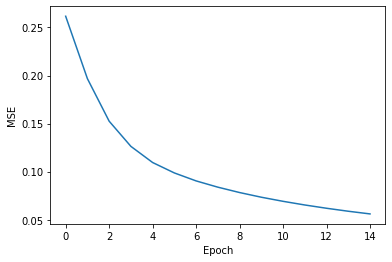

In [99]:
epochs = 15
batchsize = 100
errors = []
for i in range(epochs):
    for start, end in zip( range(0, len(train_X), batchsize), range(batchsize, len(train_X), batchsize)):
        batch = train_X[start:end]
        cur_w = sess.run(update_w, feed_dict={v0: batch, W: prv_w, vb: prv_vb, hb: prv_hb})
        cur_vb = sess.run(update_vb, feed_dict={v0: batch, W: prv_w, vb: prv_vb, hb: prv_hb})
        cur_nb = sess.run(update_hb, feed_dict={v0: batch, W: prv_w, vb: prv_vb, hb: prv_hb})
        prv_w = cur_w
        prv_vb = cur_vb
        prv_hb = cur_nb
    errors.append(sess.run(err_sum, feed_dict={v0: train_X, W: cur_w, vb: cur_vb, hb: cur_nb}))
    print ("Loss function: ", errors[-1])
plt.plot(errors)
plt.ylabel('MSE')
plt.xlabel('Epoch')
plt.show()

# Generating Recommendations

In [103]:
# Selecting a random user
inputUser = [train_X[57]]

In [104]:
# Feeding in the user to the model and reconstructing the input
hh0 = tf.nn.sigmoid(tf.matmul(v0, W) + hb)
vv1 = tf.nn.sigmoid(tf.matmul(hh0, tf.transpose(W)) + vb)
feed = sess.run(hh0, feed_dict={ v0: inputUser, W: prv_w, hb: prv_hb})
rec = sess.run(vv1, feed_dict={ hh0: feed, W: prv_w, vb: prv_vb})

In [105]:
# List the 10 most recommended books for our random user by sorting them by their probability scores 
scored_book = books_data
scored_book["Recommendation Score"] = rec[0]
scored_book.drop('Image-URL-S', axis=1).drop('Image-URL-M', axis=1).drop('Image-URL-L', axis=1)
scored_book.sort_values(["Recommendation Score"], ascending=False).head(10)

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L,List Index,Recommendation Score
67,0804106304,The Joy Luck Club,Amy Tan,1994,Prentice Hall (K-12),http://images.amazon.com/images/P/0804106304.0...,http://images.amazon.com/images/P/0804106304.0...,http://images.amazon.com/images/P/0804106304.0...,67,0.296419
118,0671027360,Angels &amp; Demons,Dan Brown,2001,Pocket Star,http://images.amazon.com/images/P/0671027360.0...,http://images.amazon.com/images/P/0671027360.0...,http://images.amazon.com/images/P/0671027360.0...,118,0.190417
1777,0553572997,The Alienist,Caleb Carr,1995,Bantam Books,http://images.amazon.com/images/P/0553572997.0...,http://images.amazon.com/images/P/0553572997.0...,http://images.amazon.com/images/P/0553572997.0...,1777,0.183232
231,0452282152,Girl with a Pearl Earring,Tracy Chevalier,2001,Plume Books,http://images.amazon.com/images/P/0452282152.0...,http://images.amazon.com/images/P/0452282152.0...,http://images.amazon.com/images/P/0452282152.0...,231,0.168121
408,0316666343,The Lovely Bones: A Novel,Alice Sebold,2002,"Little, Brown",http://images.amazon.com/images/P/0316666343.0...,http://images.amazon.com/images/P/0316666343.0...,http://images.amazon.com/images/P/0316666343.0...,408,0.167548
37,0446310786,To Kill a Mockingbird,Harper Lee,1988,Little Brown &amp; Company,http://images.amazon.com/images/P/0446310786.0...,http://images.amazon.com/images/P/0446310786.0...,http://images.amazon.com/images/P/0446310786.0...,37,0.164104
522,0312195516,The Red Tent (Bestselling Backlist),Anita Diamant,1998,Picador USA,http://images.amazon.com/images/P/0312195516.0...,http://images.amazon.com/images/P/0312195516.0...,http://images.amazon.com/images/P/0312195516.0...,522,0.154622
1985,0449212602,The Handmaid's Tale,Margaret Atwood,1989,Fawcett Books,http://images.amazon.com/images/P/0449212602.0...,http://images.amazon.com/images/P/0449212602.0...,http://images.amazon.com/images/P/0449212602.0...,1985,0.153047
748,0385504209,The Da Vinci Code,Dan Brown,2003,Doubleday,http://images.amazon.com/images/P/0385504209.0...,http://images.amazon.com/images/P/0385504209.0...,http://images.amazon.com/images/P/0385504209.0...,748,0.147531
2602,0446605239,The Notebook,Nicholas Sparks,1998,Warner Books,http://images.amazon.com/images/P/0446605239.0...,http://images.amazon.com/images/P/0446605239.0...,http://images.amazon.com/images/P/0446605239.0...,2602,0.142046


The Recommendation Score column scores probabilities of how much the book fits the user's previous interests. In other words, we can interpret the scores as the likelihood of the user reading and liking this book. Now we have to find the UserId of this user to output the final personalized recommendation. 

In [106]:
merged_data.iloc[57]

ISBN           0440234743
List Index             18
User-ID             20916
Book-Rating             7
Name: 57, dtype: object

Below are the books that our user has read before.

In [107]:
user_books_data = merged_data[merged_data['User-ID']==20916]
user_books_data.head()

,ISBN,List Index,User-ID,Book-Rating
57,0440234743,18,20916,7
23739,0446601241,1129,20916,10
74746,0671041789,5430,20916,10
199012,0451626184,37809,20916,1
199013,0451407318,37810,20916,10


Next, I merged all the books our selected user read with the predicted scores based on training data. 

In [108]:
# Merging books_df with ratings_df by ISBN
user_merged_data = scored_book.merge(user_books_data, on='ISBN', how='outer')
user_merged_data = user_merged_data.drop('List Index_y', axis=1).drop('User-ID', axis=1).drop('Image-URL-L', axis=1).drop('Image-URL-M', axis=1).drop('Image-URL-S', axis=1)

In [109]:
user_merged_data.sort_values(["Recommendation Score"], ascending=False).head(10)

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,List Index_x,Recommendation Score,Book-Rating
67,0804106304,The Joy Luck Club,Amy Tan,1994,Prentice Hall (K-12),67,0.296419,NaN
118,0671027360,Angels &amp; Demons,Dan Brown,2001,Pocket Star,118,0.190417,NaN
1777,0553572997,The Alienist,Caleb Carr,1995,Bantam Books,1777,0.183232,NaN
231,0452282152,Girl with a Pearl Earring,Tracy Chevalier,2001,Plume Books,231,0.168121,NaN
408,0316666343,The Lovely Bones: A Novel,Alice Sebold,2002,"Little, Brown",408,0.167548,NaN
37,0446310786,To Kill a Mockingbird,Harper Lee,1988,Little Brown &amp; Company,37,0.164104,NaN
522,0312195516,The Red Tent (Bestselling Backlist),Anita Diamant,1998,Picador USA,522,0.154622,NaN
1985,0449212602,The Handmaid's Tale,Margaret Atwood,1989,Fawcett Books,1985,0.153047,NaN
748,0385504209,The Da Vinci Code,Dan Brown,2003,Doubleday,748,0.147531,NaN
2602,0446605239,The Notebook,Nicholas Sparks,1998,Warner Books,2602,0.142046,NaN
